In [1]:
import tensorflow as tf
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import Utils
import os
import keras
%matplotlib inline

Using TensorFlow backend.


In [2]:
number_of_classes = 12
batch_size = 6
input_shape = (batch_size, 352, 480, 3)
label_shape = (batch_size, 352, 480, number_of_classes)
dropout_prob = 0.5
strides = (1,1,1,1)
padding = 'SAME'
max_pooling_ksize = (1,2,2,1)
learning_rate = 0.0001
num_epochs = 75

baysian_segnet_path = os.path.join('..','saved_models',"baysian_segnet","baysian_segnet_model.ckpt")
segnet_path = os.path.join('..','saved_models',"segnet","segnet_model.ckpt")

train_data_path = os.path.join("..","Data", "CamVid","train")
test_data_path = os.path.join("..","Data", "CamVid","test")
train_anno_path = os.path.join("..","Data", "CamVid","trainannot")
test_anno_path = os.path.join("..","Data", "CamVid","testannot")

class SegNet:
    
    
    def __init__(self, load_model=False, baysian=False):
        self.baysian= baysian
        
        if load_model:
            self.load_model()
        else:
            self.train_model()
            
    
    def load_model(self):
        tf.reset_default_graph()
        self.build_model()
        self.sess = tf.Session()
        
        if self.baysian:
            saver = tf.train.Saver()
            saver.restore(self.sess, baysian_segnet_path)
        else:
            saver = tf.train.import_meta_graph(segnet_path+".meta")
            saver.restore(self.sess, segnet_path+".data-00000-of-00001")
         
    
    def feed_forward(self, images):
        assert np.shape(images) == input_shape
        return self.sess.run(self.prediction, feed_dict={self.images: images})
        
    
    def predict(self, images):
        assert np.shape(images) == input_shape
        
        if self.baysian:
            predictions = []
            for i in range(50):
                predictions.append(self.feed_forward(images))
            
            return np.mean(predictions, axis=0), np.var(predictions, axis=0)
            
        else:
            return self.feed_forward(images)
        
    def build_model(self):
        self.images=tf.placeholder(dtype=tf.float32,shape=input_shape)
        self.labels_im=tf.placeholder(dtype=tf.float32,shape=label_shape)
        
        vgg16 = keras.applications.VGG16(include_top=False,weights='imagenet')
        vgg16_graph = keras.backend.get_session().graph
        w_1_1 = vgg16_graph.get_tensor_by_name('block1_conv1/kernel:0')
        b_1_1 = vgg16_graph.get_tensor_by_name('block1_conv1/bias:0')
        w_1_2 = vgg16_graph.get_tensor_by_name('block1_conv2/kernel:0')
        b_1_2 = vgg16_graph.get_tensor_by_name('block1_conv2/bias:0')

        w_2_1 = vgg16_graph.get_tensor_by_name('block2_conv1/kernel:0')
        b_2_1 = vgg16_graph.get_tensor_by_name('block2_conv1/bias:0')
        w_2_2 = vgg16_graph.get_tensor_by_name('block2_conv2/kernel:0')
        b_2_2 = vgg16_graph.get_tensor_by_name('block2_conv2/bias:0')

        w_3_1 = vgg16_graph.get_tensor_by_name('block3_conv1/kernel:0')
        b_3_1 = vgg16_graph.get_tensor_by_name('block3_conv1/bias:0')
        w_3_2 = vgg16_graph.get_tensor_by_name('block3_conv2/kernel:0')
        b_3_2 = vgg16_graph.get_tensor_by_name('block3_conv2/bias:0')
        w_3_3 = vgg16_graph.get_tensor_by_name('block3_conv3/kernel:0')
        b_3_3 = vgg16_graph.get_tensor_by_name('block3_conv3/bias:0')

        w_4_1 = vgg16_graph.get_tensor_by_name('block4_conv1/kernel:0')
        b_4_1 = vgg16_graph.get_tensor_by_name('block4_conv1/bias:0')
        w_4_2 = vgg16_graph.get_tensor_by_name('block4_conv2/kernel:0')
        b_4_2 = vgg16_graph.get_tensor_by_name('block4_conv2/bias:0')
        w_4_3 = vgg16_graph.get_tensor_by_name('block4_conv3/kernel:0')
        b_4_3 = vgg16_graph.get_tensor_by_name('block4_conv3/bias:0')

        w_5_1 = vgg16_graph.get_tensor_by_name('block5_conv1/kernel:0')
        b_5_1 = vgg16_graph.get_tensor_by_name('block5_conv1/bias:0')
        w_5_2 = vgg16_graph.get_tensor_by_name('block5_conv2/kernel:0')
        b_5_2 = vgg16_graph.get_tensor_by_name('block5_conv2/bias:0')
        w_5_3 = vgg16_graph.get_tensor_by_name('block5_conv3/kernel:0')
        b_5_3 = vgg16_graph.get_tensor_by_name('block5_conv3/bias:0')
        
        max_pooling_1, indicies_1 = self.encoding_layer(self.images, w_1_1, w_1_2, b_1_1, b_1_2, conv_stride=strides, name="Encoding_layer_1")

        max_pooling_2, indicies_2 = self.encoding_layer(max_pooling_1, w_2_1, w_2_2, b_2_1, b_2_2, conv_stride=strides, name="Encoding_layer_2")
        max_pooling_3, indicies_3 = self.encoding_layer(max_pooling_2, w_3_1, w_3_2, b_3_1, b_3_2, conv_stride=strides, name="Encoding_layer_3", filter3=w_3_3, bias3=b_3_3, dropout=self.baysian)
        max_pooling_4, indicies_4 = self.encoding_layer(max_pooling_3, w_4_1, w_4_2, b_4_1, b_4_2, conv_stride=strides, name="Encoding_layer_4", filter3=w_4_3, bias3=b_4_3, dropout=self.baysian)
        max_pooling_5, indicies_5 = self.encoding_layer(max_pooling_4, w_5_1, w_5_2, b_5_1, b_5_2, conv_stride=strides, name="Encoding_layer_5", filter3=w_5_3, bias3=b_5_3, dropout=self.baysian)

        deconv_1 = self.decoding_layer(max_pooling_5, indicies_5, w_5_1.shape[2].value, w_5_2.shape[2].value, name= "Decoding_layer_1", filter3_shape=w_5_3.shape[2].value, dropout=self.baysian)
        deconv_2 = self.decoding_layer(deconv_1, indicies_4, w_4_1.shape[2].value, w_4_2.shape[2].value, name= "Decoding_layer_2", filter3_shape=w_4_3.shape[2].value, dropout=self.baysian)
        deconv_3 = self.decoding_layer(deconv_2, indicies_3, w_3_1.shape[2].value, w_3_2.shape[2].value, name= "Decoding_layer_3", filter3_shape=w_3_3.shape[2].value, dropout=self.baysian)
        deconv_4 = self.decoding_layer(deconv_3, indicies_2, w_2_1.shape[2].value, w_2_2.shape[2].value, name= "Decoding_layer_4")
        deconv_5 = self.decoding_layer(deconv_4, indicies_1, number_of_classes, w_1_2.shape[2].value, name= "Decoding_layer_5")

        out = tf.nn.softmax(deconv_5)

        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=self.labels_im))
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        self.prediction = tf.argmax(out,-1)
        correctPred = tf.equal(self.prediction, tf.argmax(self.labels_im,-1))
        self.accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))
    
    def train_model(self):
        train_accu = tf.summary.scalar("train_accu", self.accuracy)
        train_loss = tf.summary.scalar("train_loss", self.loss)
        train_summ = tf.summary.merge((train_accu, train_loss))
        
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
        if self.baysian:
            logdir = os.path.join("tensorboard_logs","Baysian_SegNet")
        else:
            logdir = os.path.join("tensorboard_logs","SegNet")
        writer = tf.summary.FileWriter(logdir)
        writer.add_graph(self.sess.graph)
        saver = tf.train.Saver()
        
        train_images = np.asarray(Utils.load_images(train_data_path))
        test_images = np.asarray(Utils.load_images(test_data_path))
        
        train_annotations = np.asarray(Utils.load_annotations(train_anno_path))
        test_annotations = np.asarray(Utils.load_annotations(test_anno_path))
        
        training_bp = Utils.BatchProcessor()
        test_bp = Utils.BatchProcessor()
        
        for i in range(int(num_epochs*len(train_images) / batch_size)):
            batch_X, batch_y = training_bp.get_next_batch(train_images, train_annotations, batch_size)

            self.sess.run(train_step,feed_dict={self.images: batch_X,self.labels_im: batch_y})

            if i % 50 == 0:
                accus = []
                losss = []
                for j in range(int(len(test_images)/batch_size)):
                    test_batch_x, test_batch_y = test_bp.get_next_batch(test_images, test_annotations, batch_size)
                    loss_o, accu_o = self.sess.run([loss,accuracy],feed_dict={self.images: test_batch_x,self.labels_im: test_batch_y})
                    accus.append(accu_o)
                    losss.append(loss_o)
                train_summary = self.sess.run(train_summ,feed_dict={self.images: batch_X,self.labels_im: batch_y})
                writer.add_summary(train_summary, i)

                test_sum = tf.Summary()
                test_sum.value.add(tag="TestAccuracy", simple_value =np.mean(accus))
                writer.add_summary(test_sum, i)
                print("{2}/{3} Test accu: {0}, test loss: {1}".format(np.mean(accus), np.mean(losss), i, int(num_epochs*len(train_images) / batch_size)))

            if i % 1000 == 0 and i!=0:
                if self.baysian:
                    save_path = saver.save(self.sess, baysian_segnet_path)
                else:
                    save_path = saver.save(self.sess, segnet_path)
                
                print("Model saved to: %s" % save_path)

        
    def encoding_layer(self, input, filter1, filter2, bias1, bias2, conv_stride, name=None, filter3=None, bias3=None, max_pool_stride = (1,2,2,1), dropout=False):
        with tf.name_scope(name):
            conv_1= tf.layers.batch_normalization(tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = input,filter=filter1, strides=conv_stride, padding=padding), bias1)))
            conv_2= tf.layers.batch_normalization(tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_1,filter=filter2, strides=conv_stride, padding=padding), bias2)))
            if filter3 != None and bias3 != None:
                conv_3 = tf.layers.batch_normalization(tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input = conv_2,filter=filter3, strides=conv_stride, padding=padding), bias3)))
                
                max_pool, indicies = tf.nn.max_pool_with_argmax(conv_3, ksize=max_pooling_ksize,strides=(1,2,2,1), padding='VALID')
            else:
                max_pool, indicies = tf.nn.max_pool_with_argmax(conv_2, ksize=max_pooling_ksize,strides=(1,2,2,1), padding='VALID')
            
            if dropout:
                return tf.nn.dropout(max_pool, keep_prob=1-dropout_prob), indicies
            else:
                return max_pool, indicies

    def decoding_layer(self, input, indicies, filter1_shape, filter2_shape, name=None, filter3_shape=None, dropout=False):
        with tf.name_scope(name):
            upsample = Utils.unpool_with_argmax(input, indicies, name=name+"Upsample")
            if filter3_shape != None:
                deconv_1 = tf.layers.batch_normalization(tf.layers.conv2d(upsample, filter3_shape,(3,3),activation=tf.nn.relu, padding='same', kernel_initializer=tf.contrib.layers.variance_scaling_initializer()))
                deconv_2 = tf.layers.batch_normalization(tf.layers.conv2d(deconv_1, filter2_shape,(3,3),activation=tf.nn.relu, padding='same',kernel_initializer=tf.contrib.layers.variance_scaling_initializer()))
                max_pool =  tf.layers.batch_normalization(tf.layers.conv2d(deconv_2, filter1_shape,(3,3),activation=tf.nn.relu, padding='same', kernel_initializer=tf.contrib.layers.variance_scaling_initializer()))
            else:
                deconv_1 = tf.layers.batch_normalization(tf.layers.conv2d(upsample, filter2_shape,(3,3),activation=tf.nn.relu, padding='same',kernel_initializer=tf.contrib.layers.variance_scaling_initializer()))
                max_pool =  tf.layers.batch_normalization(tf.layers.conv2d(deconv_1, filter1_shape,(3,3),activation=tf.nn.relu, padding='same', kernel_initializer=tf.contrib.layers.variance_scaling_initializer()))
                
            if dropout:
                return tf.nn.dropout(max_pool, keep_prob=1-dropout_prob)
            else:
                return max_pool

    

In [3]:
segnet = SegNet(load_model=True, baysian=True)

input_shape: (6, 11, 15, 512), ind: (6, 11, 15, 512)
input_shape: (6, 22, 30, 512), ind: (6, 22, 30, 512)
input_shape: (6, 44, 60, 256), ind: (6, 44, 60, 256)
input_shape: (6, 88, 120, 128), ind: (6, 88, 120, 128)
input_shape: (6, 176, 240, 64), ind: (6, 176, 240, 64)
INFO:tensorflow:Restoring parameters from ..\saved_models\baysian_segnet\baysian_segnet_model.ckpt


In [4]:
images = Utils.load_images(test_data_path, amount=batch_size)
prediciton = segnet.predict(images)

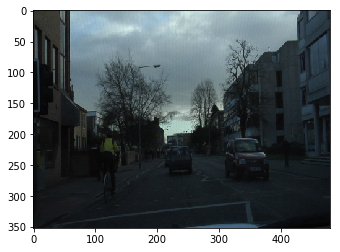

In [9]:
plt.imshow(images[1])

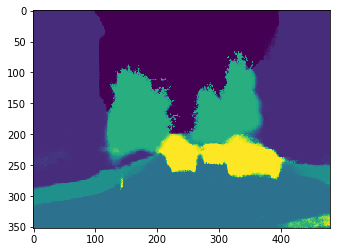

In [21]:
plt.imshow(prediciton[0][0])

In [16]:
annos = np.argmax(Utils.load_annotations(test_anno_path), axis=-1)

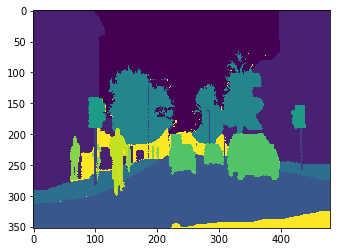

In [18]:
plt.imshow(annos[0])

In [ ]:
segnet = SegNet(load_model=False, baysian=True)